In [1]:
import getpass
import json as json
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from itertools import compress
from sklearn import covariance, cluster

%matplotlib inline 

# Monitoring Trigger Rates: Generate Covarience for a Given Fill

In [2]:
READ_PATH = "./data"
WRITE_PATH = "./matrix_visualization/static"
DATA_PATH = "/eos/cms/store/cmst3/group/dehep/adpol/trigger"

In [3]:
# Get pass for EOS

os.system("echo %s | kinit" % getpass.getpass())

········


0

In [4]:
# Load information about available rates and their fits

rates = pd.read_csv("./data/rates_with_fit.csv",
                    dtype={"trigger": str,
                           "function": str,
                           "sigma": float,
                           "run": int,
                           "mode": str},
                    index_col=0)
rates.head(1)

,trigger,function,sigma,run,mode
0,AlCa_EcalEtaEBonly,-0.577724010406387+x*(0.062083640099194+ x*(-0...,0.357559,304797,l1_hlt_collisions2017/v282


In [5]:
# Add LHC fill number

fills = pd.read_csv("./data/lhc_fills.csv",
                    names=["run", "fill"])
rates = pd.merge(rates, fills, on="run")
rates.head(1)

,trigger,function,sigma,run,mode,fill
0,AlCa_EcalEtaEBonly,-0.577724010406387+x*(0.062083640099194+ x*(-0...,0.357559,304797,l1_hlt_collisions2017/v282,6291


In [6]:
print("Total number of runs: %s" % len(rates.run.unique()))
print("Total number of fills: %s" % len(rates.fill.unique()))

Total number of runs: 272
Total number of fills: 105


In [7]:
# Select globals for study

SELECT_FILLS = [6287]

SELECT_RUNS = rates[rates["fill"].isin(SELECT_FILLS)]["run"].values

SELECT_TRIGGERS = list(
    set(
        rates[rates.trigger.str.contains("Mu", na=False) & rates.trigger.str.contains("HLT", na=False) &
             (rates.fill.isin(SELECT_FILLS))].trigger.unique().tolist() + 
        rates[rates.trigger.str.contains("EG", na=False) & rates.trigger.str.contains("HLT", na=False) &
             (rates.fill.isin(SELECT_FILLS))].trigger.unique().tolist() +
        rates[rates.trigger.str.contains("Ele", na=False) & rates.trigger.str.contains("HLT", na=False) &
             (rates.fill.isin(SELECT_FILLS))].trigger.unique().tolist()
    )
)

SELECT_TRIGGERS = sorted(SELECT_TRIGGERS)

In [8]:
# Load rates

data_rates = pd.DataFrame()
for _, sample in rates[rates.trigger.isin(SELECT_TRIGGERS)].iterrows():
    
    if not sample["run"] in SELECT_RUNS:
        continue

    try:
        # Load rates from .npy
        rates_array = np.load("%s/%s/%s.npy" % 
                              (DATA_PATH, sample["run"], sample["trigger"]))

        # Save rates to dataframe
        sample["rates"] = rates_array
    except:
        sample["rates"] = np.nan
        
    data_rates = data_rates.append(pd.Series(sample))

In [9]:
data_rates.dropna(inplace=True)
SELECT_RUNS = data_rates.run.unique()

In [10]:
# Combine rates vs fill

data = pd.DataFrame()

for fill in SELECT_FILLS:
    for trigger in SELECT_TRIGGERS:

        function = None
        sigma = None
        runs = []
        rates = np.empty((2,0))
        for _, sample in data_rates[(data_rates["trigger"] == trigger) &
                                    (data_rates["fill"] == fill)].sort_values(by=["run"]).iterrows():
            # Append rates
            rates_array = np.hstack((rates, np.array(sample["rates"])))
            
            # Sort rates based on <PU>
            rates_sorted = rates_array[:,np.argsort(rates_array[0])]
            
            # Reverse sorting
            rates_sorted =  np.fliplr(rates_sorted)
            
            runs.append(sample["run"])
            if function is None:
                function = sample["function"]
                sigma = sample["sigma"]

        if len(runs) != len(SELECT_RUNS):
            continue
                
        data = data.append(pd.Series({"prediciton": function,
                                      "sigma": sigma,
                                      "fill": fill,
                                      "rates": rates_sorted,
                                      "trigger": trigger}),
                           ignore_index=True)

In [11]:
# Fix predictions

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def correct_prediction(rates):
    model = Pipeline([("poly", PolynomialFeatures(degree=3)),
                      ("linear", LinearRegression(fit_intercept=False))])

    model.fit(rates[0].reshape(-1, 1), rates[1].reshape(-1, 1))
    return "%s+x*%s+x*x*%s+x*x*x*%s" % tuple(model.named_steps["linear"].coef_[0])
    
data["prediciton"] = data["rates"].apply(correct_prediction)

In [12]:
SELECT_TRIGGERS = data.trigger.unique()

## Covariance

In [13]:
# Utilities

def find_common_pu(pileups):  
    common_pu = np.array([])
    for pu in pileups[0]:
        include = True
        for pus in pileups:
            if pu not in pus:
                include = False
        if include:
            common_pu = np.append(common_pu, pu)
    return common_pu

def eq_seq(ref, rates):
    indexes = []
    for i in range(len(rates)):
        if not rates[i] in ref:
            indexes.append(i)
    return indexes

def normalize_to_prediction(x, function):
    return eval(function.replace('sinh', 'np.sinh'))

def calculate_first_differences(rates):
    seq = []
    for i in range(len(rates)-1):
        seq.append(rates[i + 1] - rates[i])
    return seq

def calculate_link_relatives(rates):
    seq = []
    for i in range(len(rates)-1):
        seq.append(rates[i + 1] / rates[i])
    return seq

def plot_covariance(my_covariance):
    fig = plt.figure()
    vmax = my_covariance.max()
    plt.figure(figsize=(24, 14))
    plt.imshow(my_covariance, interpolation='nearest', vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r)
    plt.colorbar()
    plt.show()

def export_data_for_d3(cm, cluster, file_name):
    nodes = []
    for trigger, group in zip(SELECT_TRIGGERS, cluster):
        nodes.append({"name": trigger,
                      "group": int(group)})

    links = []
    itter = len(SELECT_TRIGGERS)
    for i in range(itter):
        for j in range(i, itter):
            links.append({"source": i,
                          "target": j,
                          "value": cm[i][j]})

    with open(file_name, "w") as file:
        
        file.write(json.dumps({"nodes": nodes,
                               "links": links}))

In [14]:
def calculate_covariance(fills, triggers, require_modeling=False,
                         first_differences=False, link_relatives=False, fraction=1.0):

    number_of_triggers = len(triggers)
    covariance_matrix = np.zeros([number_of_triggers, number_of_triggers])
    itterations = 0

    for fill in fills:

        if (len(data[data.fill == fill]) == len(triggers)):

            # Change time series to follow the same <pu>
            rates = [r[1] for r in data[data.fill == fill].rates.values]
            pu = [r[0] for r in data[data.fill == fill].rates.values]
            
            common_pu = find_common_pu(pu)
            common_pu = common_pu[:int(fraction*len(common_pu))]
            
            for i in range(number_of_triggers):
                indexes = eq_seq(common_pu, pu[i])
                rates[i] = np.delete(rates[i], indexes)

            # De-trending: Substract prediction
            if require_modeling:
                predict = data[data.fill == fill].prediciton.values
                for i in range(number_of_triggers):
                    rates[i] = rates[i] - normalize_to_prediction(common_pu, predict[i])                   
                   
            # De-trending: Calculate first differences
            if first_differences:
                rates = [calculate_first_differences(r) for r in rates]
            
            # De-trending: Calculate link relatives
            if link_relatives:
                rates = [calculate_link_relatives(r) for r in rates]
                
            var = np.concatenate(rates).reshape(len(triggers), -1)
            X = var.copy().T
            X /= X.std(axis=0)

            #edge_model = covariance.GraphLassoCV()
            #edge_model.fit(X)
            #covariance_matrix = covariance_matrix + edge_model.covariance_

            edge_model = covariance.empirical_covariance(X)
            covariance_matrix = covariance_matrix + edge_model

            itterations += 1
                
    return covariance_matrix / itterations

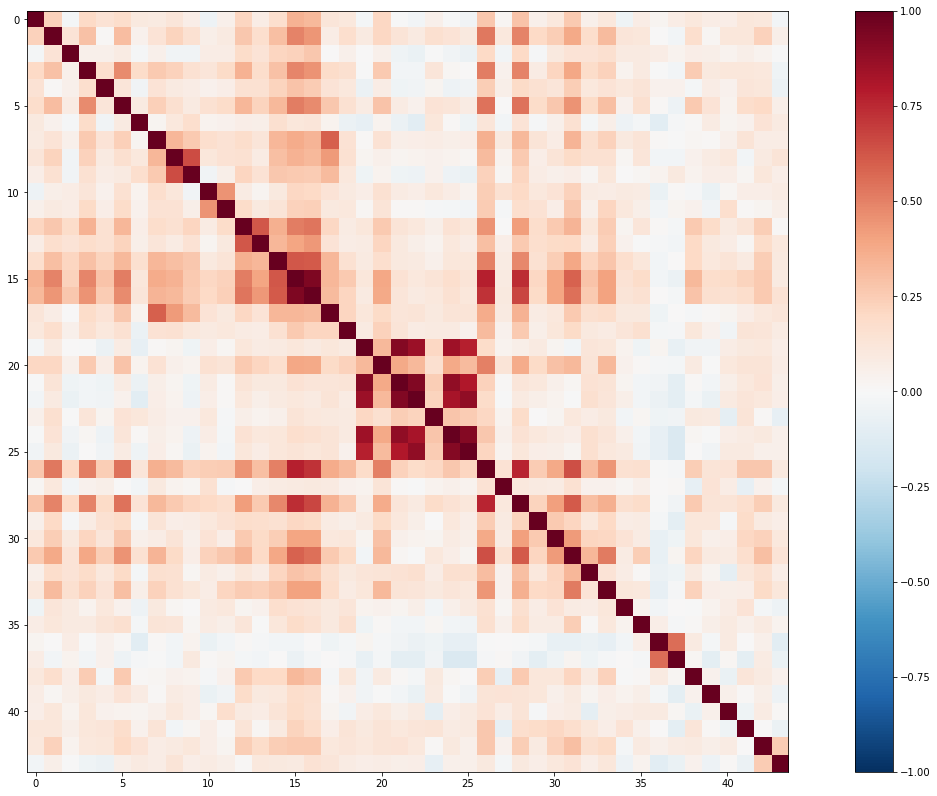

In [15]:
for fraction in range(10, 101, 10):
    fraction = fraction/100
    for flags in [(0,0,0), (1,0,0), (0,1,0), (1,1,0), (1,0,1), (1,1,1)]:
        covariance_matrix = calculate_covariance(SELECT_FILLS, SELECT_TRIGGERS,
                                                 flags[0], flags[1], flags[2],
                                                fraction)
        _, labels = cluster.affinity_propagation(covariance_matrix)
        json_name = "%s/data/data%sfrac%s.json" % (WRITE_PATH,
                                             ''.join(str(i) for i in flags),
                                            int(fraction*100))
        export_data_for_d3(covariance_matrix, labels, json_name)
        if set(flags) == {0} and fraction == 1:
            plot_covariance(covariance_matrix)

In [16]:
def PlotTrigger(ax, sample):
    x = sample.rates[0]
    prediction = eval(sample.prediciton.replace('sinh', 'np.sinh'))
    smax = prediction + sample.sigma
    smin = prediction - sample.sigma
    
    ax.plot(x, sample.rates[1], 'bo', markersize=2)
    ax.plot(x, prediction, 'r-', alpha=0.5)
    ax.fill_between(x, smax, smin, color='red', alpha=0.2)

for _, sample in data.iterrows():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    PlotTrigger(ax, sample)
    ax.set_title("%s" % (sample.trigger))
    ax.set_ylabel("Rate [Hz]")
    ax.set_xlabel("<PU>")
    plt.savefig('%s/figures/%s.png' % (WRITE_PATH, sample.trigger));
    plt.close(fig)